In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from scipy import stats
# from utils import get_momp
from matplotlib.gridspec import GridSpec
import matplotlib.gridspec as gridspec
import numpy as np
import os
# os.environ['PYOPENCL_CTX'] = '0'
from pysb.simulator import CudaSSASimulator, OpenCLSSASimulator, BngSimulator, StochKitSimulator

from pysb.examples.schloegl import model as scholgl_model
from pysb.examples.michment import model as michment
from pysb.examples.kinase_cascade import model as kinase_model
from pysb.examples.earm_1_0 import model as earm_1

In [2]:
VERBOSE = True

In [4]:
cols = ['simulation', 'time', 'Bid_unbound', 'PARP_unbound', 'mSmac_unbound',
                              'tBid_total', 'CPARP_total', 'cSmac_total']
bng_data = pd.read_csv('bng_10000_output.csv', usecols=cols)
gpu_data = pd.read_csv('gpu_10000_output.csv', usecols=cols)

time = bng_data.loc[bng_data['simulation'] == 1, ['time']].values

In [11]:
def create_ks_stats(traj1, traj2, obs, tspan2, prefix, labels):
    traj1['simulator'] = labels[0]
    traj2['simulator'] = labels[1]
    tspan = tspan2
    df = pd.concat([traj1, traj2], ignore_index=True)
    try:
        # used if reading in data.
        traj1 = traj1.set_index(['time', 'simulation'])
        traj2 = traj2.set_index(['time', 'simulation'])
    except:
        pass
    
    traj1_species = traj1[obs].unstack('simulation').values
    traj2_species = traj2[obs].unstack('simulation').values

    
    color_1, color_2, color_3 = 'red', 'blue', 'xkcd:orchid'
    label_3 = '|{}-{}|'.format(labels[0], labels[1])
    labels.append(label_3)
    
    red_patch = Line2D([0], [0], color=color_1, label=labels[0], linewidth=0, marker='x')
    blue_patch = Line2D([0], [0], color=color_2, label=labels[1], linewidth=0, marker='+')
    orchid_patch = Line2D([0], [0], color=color_3, label=labels[1], linewidth=0, marker='.')
    patches = [red_patch, blue_patch, orchid_patch]
    

    fig = plt.figure(figsize=(16, 8))

    gs0 = gridspec.GridSpec(2, 1, figure=fig)
    gs00 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[0], wspace=.2)
    gs01 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[1], wspace=.4)
    
    ax1 = fig.add_subplot(gs00[0, 0])
    ax2 = fig.add_subplot(gs00[0, 1])
    ax3 = fig.add_subplot(gs01[0, 0])
    ax4 = fig.add_subplot(gs01[0, 1])
    ax5 = fig.add_subplot(gs01[0, 2])
    
#     ax1.set_title(labels[0])
#     ax1.plot(tspan, traj1_species, lw=1, alpha=0.15,)
#     ax1.set_ylabel("Number of molecules")
#     ax1.set_xlabel("Time(hr)")
    
#     ax2.set_title(labels[1])
#     ax2.plot(tspan, traj2_species, lw=1, alpha=0.15,)
#     ax2.set_ylabel("Number of molecules")
#     ax2.set_xlabel("Time(hr)")

    args1 = dict(color=color_1, marker='x', label=labels[0], linestyle='')
    args2 = dict(color=color_2, marker='+', label=labels[1], linestyle='')
    args3 = dict(color=color_3, marker='.', label=labels[2])
    
    ax3.set_title('{} mean'.format(obs))
    ax3.plot(tspan, np.average(traj1_species, axis=1),  **args1)
    ax3.plot(tspan, np.average(traj2_species, axis=1),  **args2)
    ax3.set_ylabel("Number of molecules")
    ax3.set_xlabel("Time(hr)")
    ax3.legend(
        handles=patches, 
        labels=labels, 
        loc='upper left'
    )
    
    ax3_1 = ax3.twinx()  # instantiate a second axes that shares the same x-axis
    ax3_1.plot(tspan, np.abs(np.average(traj1_species, axis=1)-np.average(traj2_species, axis=1)), **args3)
#     ax3_1.set_ylabel("Number of molecules")
    
    ax4.set_title('{} standard deviation'.format(obs))
    ax4.plot(tspan, np.std(traj1_species, axis=1),  **args1)
    ax4.plot(tspan, np.std(traj2_species, axis=1),  **args2)
#     ax4.set_ylabel("Number of molecules")
    ax4.set_xlabel("Time(hr)")
    ax4.legend(
        handles=patches, 
        labels=labels, 
        loc='upper left'
    )
    
    ax4_1 = ax4.twinx()  # instantiate a second axes that shares the same x-axis
#     ax4_1.set_ylabel(args3['label'], color=color_3)  # we already handled the x-label with ax1
    l3 = ax4_1.plot(tspan, np.abs(np.std(traj1_species, axis=1)-np.std(traj2_species, axis=1)), **args3)
#     ax4_1.tick_params(axis='y', labelcolor=color_3)
#     ax4_1.set_ylabel("Number of molecules")


    n_timesteps = len(tspan)
    p_values = np.zeros(n_timesteps)
    ks_stats = np.zeros(n_timesteps)

    expand = False
    for i in range(n_timesteps):
        t1, t2 = traj1_species[i], traj2_species[i]
        ks_stats[i], p_values[i] = stats.ks_2samp(t1, t2, mode='exact')
#         p_values[i] = stats.wasserstein_distance(t1, t2)
        # ks_stats[i], p_values[i] = stats.chisquare(t1, t2)
        # ks_stats[i], p_values[i] = stats.wilcoxon(t1, t2)
        # ks_stats[i], p_values[i] = stats.ttest_rel(t1, t2, nan_policy='omit')
        
    min_p_value = np.min(p_values)
    at_time = tspan[np.argmin(p_values)]
    print("min p: {} at time point {}".format(min_p_value, at_time))

    ax5.set_title('Kolmogorow Smirnow test between \nBNG and CUDASimulator over time')
    ax5.plot(tspan, p_values, label=obs)
    ax5.set_ylabel("p value")
    ax5.set_xlabel("Time(hr)")
    plt.subplots_adjust(hspace=.45)
    s_name = "compare_sims_{}_{}".format(prefix, obs)
    plt.savefig(s_name+'.pdf', bbox_inches='tight')
    plt.savefig(s_name+'.png', bbox_inches='tight')

min p: 0.1111339652837609 at time point [20000.]


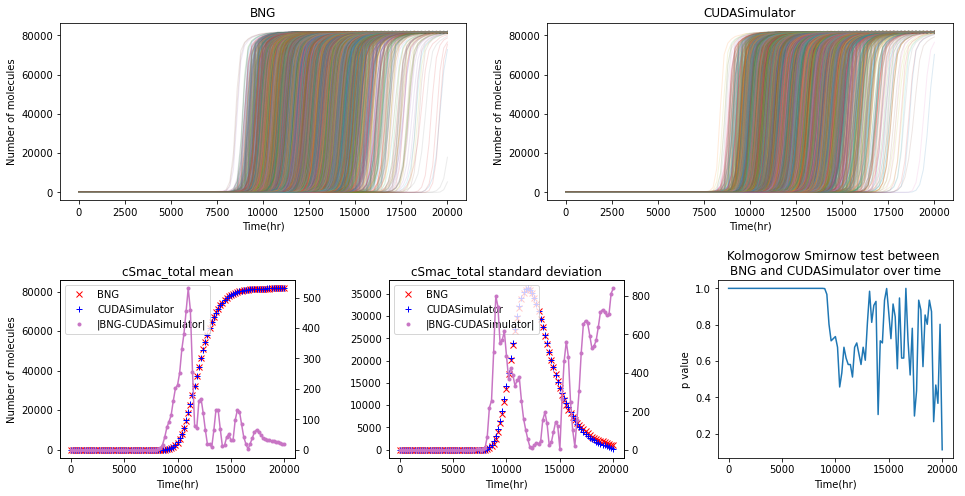

In [5]:
create_ks_stats(bng_data, gpu_data, 'cSmac_total', time, 'bng_cuda', ['BNG', 'CUDASimulator'])

min p: 0.2809396165446236 at time point [17000.]


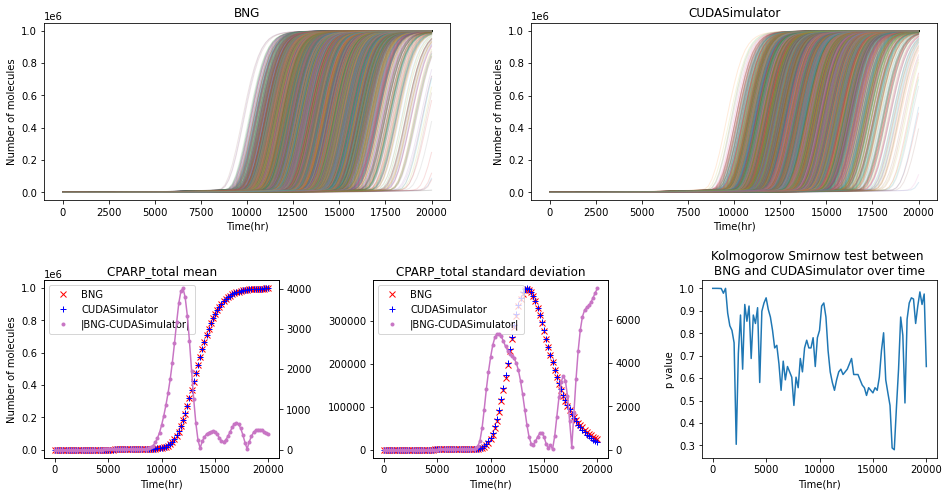

In [6]:
create_ks_stats(bng_data, gpu_data, 'CPARP_total', time, 'bng_cuda', ['BNG', 'CUDASimulator'])

In [15]:
def compare_cuda_twice(model, t_end, n_timesteps, obs, n_sim):
    tspan = np.linspace(0, t_end, n_timesteps)
    cuda_sim = CudaSSASimulator(model, tspan=tspan)
    cuda_traj1 = cuda_sim.run(number_sim=n_sim).dataframe
    cuda_traj2 = cuda_sim.run(number_sim=n_sim).dataframe
    create_ks_stats(cuda_traj1, cuda_traj2, obs, tspan, prefix='cuda_vs_cuda', labels=['Run 1', 'Run 2'])
    
def compare_opencl_twice(model, t_end, n_timesteps, obs, n_sim):
    tspan = np.linspace(0, t_end, n_timesteps)
    opencl_sim = OpenCLSSASimulator(model, tspan=tspan)
    traj1 = opencl_sim.run(number_sim=n_sim).dataframe
    traj2 = opencl_sim.run(number_sim=n_sim).dataframe
    create_ks_stats(traj1, traj2, obs, tspan, prefix='opencl_vs_opencl', labels=['Run 1', 'Run 2'])
    
def compare_cuda_opencl(model, t_end, n_timesteps, obs, n_sim):
    tspan = np.linspace(0, t_end, n_timesteps)

    cuda_sim = CudaSSASimulator(model, tspan=tspan, verbose=VERBOSE)

    opencl_sim = OpenCLSSASimulator(model, tspan=tspan, verbose=VERBOSE)

    cuda_traj = cuda_sim.run(number_sim=n_sim).dataframe
    opencl_traj = opencl_sim.run(number_sim=n_sim).dataframe
    create_ks_stats(cuda_traj, opencl_traj, obs, tspan, prefix='cuda_vs_opencl', labels=['CUDA', 'OpenCL'])
    
def compare_opencl_precision(model, t_end, n_timesteps, obs, n_sim):
    tspan = np.linspace(0, t_end, n_timesteps)
    opencl_sim1 = OpenCLSSASimulator(model, tspan=tspan, verbose=VERBOSE, precision=np.float64)
    opencl_traj1 = opencl_sim1.run(number_sim=n_sim).dataframe
    
    opencl_sim2 = OpenCLSSASimulator(model, tspan=tspan, verbose=VERBOSE, precision=np.float32)
    opencl_traj2 = opencl_sim2.run(number_sim=n_sim).dataframe
    create_ks_stats(opencl_traj1, opencl_traj2, obs, tspan, prefix='opencl_precision',  labels=['double', 'float'])
    
def compare_cuda_precision(model, t_end, n_timesteps, obs, n_sim):
    tspan = np.linspace(0, t_end, n_timesteps)
    sim1 = CudaSSASimulator(model, tspan=tspan, verbose=VERBOSE, precision=np.float64)
    traj1 = sim1.run(number_sim=n_sim).dataframe
    
    sim2 = CudaSSASimulator(model, tspan=tspan, verbose=VERBOSE, precision=np.float32)
    traj2 = sim2.run(number_sim=n_sim).dataframe
    create_ks_stats(traj1, traj2, obs, tspan, prefix='cuda_precision',  labels=['double', 'float'])

2021-01-22 13:51:32.291 - pysb.bng - INFO - [pysb.examples.schloegl] Generating reaction network
2021-01-22 13:51:32.522 - pysb - INFO - Logging started on PySB version 1.11.0+170.g43c73d5.dirty
2021-01-22 13:51:32.522 - pysb - INFO - Log entry time offset from UTC: -8.00 hours
2021-01-22 13:51:32.527 - pysb.simulator.opencl_ssa - INFO - [pysb.examples.schloegl] Initialized OpenCLSSASimulator class
2021-01-22 13:51:32.528 - pysb.simulator.opencl_ssa - INFO - [pysb.examples.schloegl] Simulation(s) started
2021-01-22 13:51:32.540 - pysb.simulator.opencl_ssa - INFO - [pysb.examples.schloegl] Output OpenCl file to ssa_opencl_code.cl
2021-01-22 13:51:32.692 - pysb.simulator.opencl_ssa - INFO - [pysb.examples.schloegl] Using device GeForce RTX 3090
2021-01-22 13:51:32.945 - pysb.simulator.opencl_ssa - INFO - [pysb.examples.schloegl] Creating content on device
2021-01-22 13:51:34.734 - pysb.simulator.opencl_ssa - INFO - [pysb.examples.schloegl] 1000 simulations in 1.7880s
2021-01-22 13:51:35.

min p: 0.012912352230759101 at time point 66.5


2021-01-22 13:51:37.736 - pysb.simulator.opencl_ssa - INFO - [pysb.examples.schloegl] Initialized OpenCLSSASimulator class
2021-01-22 13:51:37.737 - pysb.simulator.opencl_ssa - INFO - [pysb.examples.schloegl] Simulation(s) started
2021-01-22 13:51:37.830 - pysb.simulator.opencl_ssa - INFO - [pysb.examples.schloegl] Using device GeForce RTX 3090
2021-01-22 13:51:37.976 - pysb.simulator.opencl_ssa - INFO - [pysb.examples.schloegl] Creating content on device
2021-01-22 13:51:39.571 - pysb.simulator.opencl_ssa - INFO - [pysb.examples.schloegl] 1000 simulations in 1.5940s
2021-01-22 13:51:39.643 - pysb.simulator.opencl_ssa - INFO - [pysb.examples.schloegl] Simulation(s) started
2021-01-22 13:51:39.655 - pysb.simulator.opencl_ssa - INFO - [pysb.examples.schloegl] Creating content on device
2021-01-22 13:51:41.254 - pysb.simulator.opencl_ssa - INFO - [pysb.examples.schloegl] 1000 simulations in 1.5985s


min p: 0.01960232095219542 at time point 32.0


2021-01-22 13:51:42.445 - pysb.simulator.cuda_ssa - INFO - [pysb.examples.schloegl] Initialized CudaSSASimulator class
2021-01-22 13:51:42.446 - pysb.simulator.cuda_ssa - INFO - [pysb.examples.schloegl] Simulation(s) started
2021-01-22 13:51:42.458 - pysb.simulator.cuda_ssa - INFO - [pysb.examples.schloegl] Using device GeForce RTX 3090
2021-01-22 13:51:43.498 - pysb.simulator.cuda_ssa - INFO - [pysb.examples.schloegl] Creating content on device
2021-01-22 13:51:43.523 - pysb.simulator.cuda_ssa - INFO - [pysb.examples.schloegl] Completed transfer in: 0.0245s
2021-01-22 13:51:43.524 - pysb.simulator.cuda_ssa - INFO - [pysb.examples.schloegl] Starting 1000 simulations on 32 blocks
2021-01-22 13:51:45.105 - pysb.simulator.cuda_ssa - INFO - [pysb.examples.schloegl] 1000 simulations in 1.5800s
2021-01-22 13:51:45.214 - pysb.simulator.cuda_ssa - INFO - [pysb.examples.schloegl] Simulation(s) started
2021-01-22 13:51:45.226 - pysb.simulator.cuda_ssa - INFO - [pysb.examples.schloegl] Using devi

min p: 0.008353146175741297 at time point 15.0


2021-01-22 13:51:48.046 - pysb - INFO - Logging started on PySB version 1.11.0+170.g43c73d5.dirty
2021-01-22 13:51:48.047 - pysb - INFO - Log entry time offset from UTC: -8.00 hours
2021-01-22 13:51:48.051 - pysb.simulator.cuda_ssa - INFO - [pysb.examples.schloegl] Initialized CudaSSASimulator class
2021-01-22 13:51:48.051 - pysb.simulator.cuda_ssa - INFO - [pysb.examples.schloegl] Simulation(s) started
2021-01-22 13:51:48.063 - pysb.simulator.cuda_ssa - INFO - [pysb.examples.schloegl] Using device GeForce RTX 3090
2021-01-22 13:51:48.064 - pysb.simulator.cuda_ssa - INFO - [pysb.examples.schloegl] Output cuda file to ssa_cuda_code.cu
2021-01-22 13:51:49.085 - pysb.simulator.cuda_ssa - INFO - [pysb.examples.schloegl] Creating content on device
2021-01-22 13:51:49.111 - pysb.simulator.cuda_ssa - INFO - [pysb.examples.schloegl] Completed transfer in: 0.0255s
2021-01-22 13:51:49.112 - pysb.simulator.cuda_ssa - INFO - [pysb.examples.schloegl] Starting 1000 simulations on 32 blocks
2021-01-2

min p: 0.008353146175741297 at time point 92.0


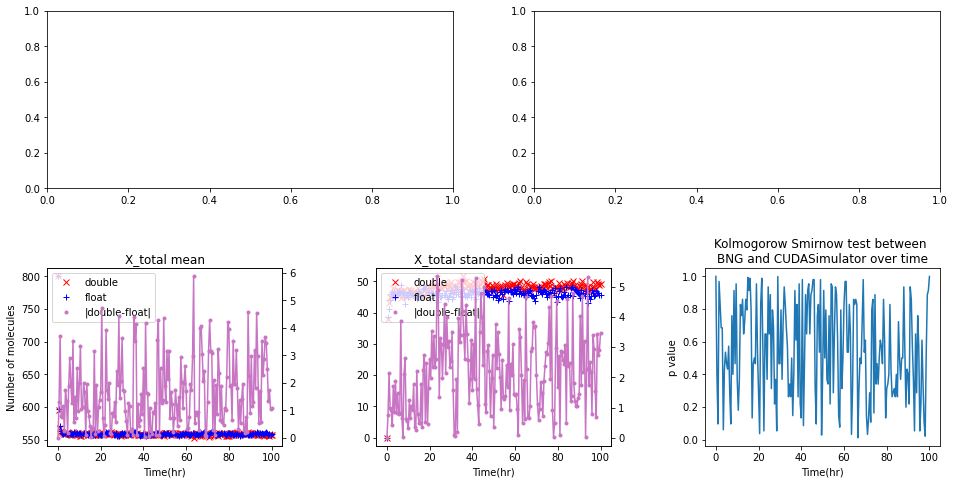

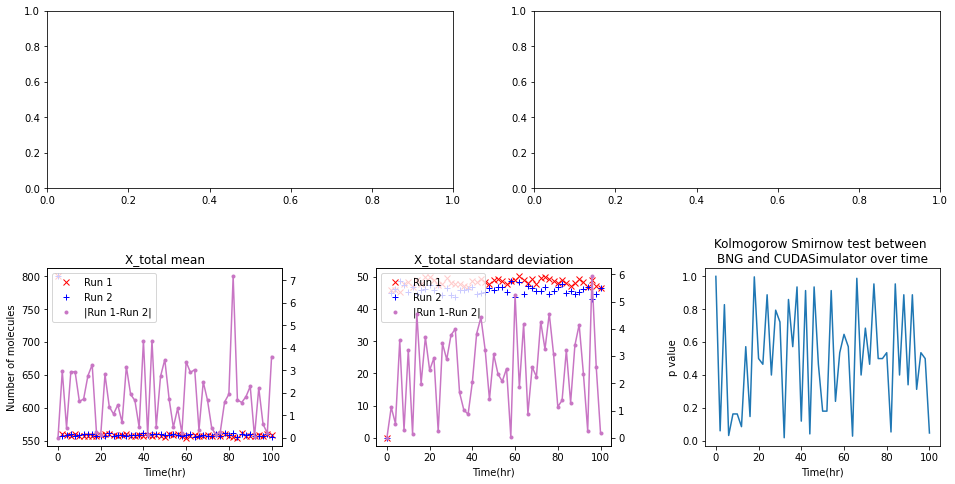

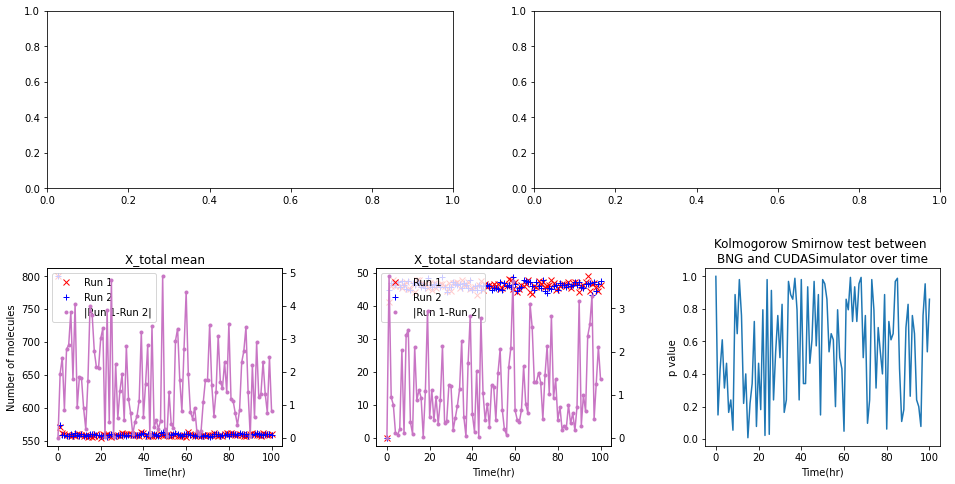

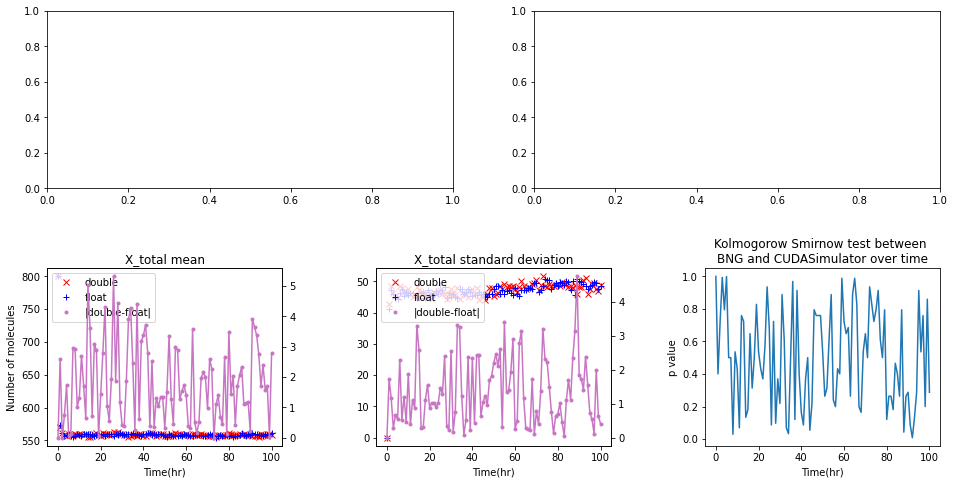

In [17]:
import os
os.environ['PYOPENCL_CTX'] = '0'
n_sim = 1000
scholgl_model.parameters['X_0'].value = 800
compare_opencl_precision(scholgl_model, 100, 201, 'X_total', n_sim)
compare_opencl_twice(scholgl_model, 100, 51, 'X_total', n_sim)
compare_cuda_twice(scholgl_model, 100, 101, 'X_total', n_sim)
compare_cuda_precision(scholgl_model, 100, 101, 'X_total', n_sim)

2021-01-22 13:45:14.285 - pysb.simulator.opencl_ssa - INFO - [pysb.examples.earm_1_0] Initialized OpenCLSSASimulator class
2021-01-22 13:45:14.287 - pysb.simulator.opencl_ssa - INFO - [pysb.examples.earm_1_0] Simulation(s) started
2021-01-22 13:45:15.604 - pysb.simulator.opencl_ssa - INFO - [pysb.examples.earm_1_0] Using device GeForce RTX 3090
2021-01-22 13:45:15.969 - pysb.simulator.opencl_ssa - INFO - [pysb.examples.earm_1_0] Creating content on device
2021-01-22 13:45:20.411 - pysb.simulator.opencl_ssa - INFO - [pysb.examples.earm_1_0] 10000 simulations in 4.4410s
2021-01-22 13:45:25.196 - pysb.simulator.opencl_ssa - INFO - [pysb.examples.earm_1_0] Simulation(s) started
2021-01-22 13:45:26.361 - pysb.simulator.opencl_ssa - INFO - [pysb.examples.earm_1_0] Creating content on device
2021-01-22 13:45:32.584 - pysb.simulator.opencl_ssa - INFO - [pysb.examples.earm_1_0] 10000 simulations in 6.2220s


min p: 0.01581175286855823 at time point 7400.0


2021-01-22 13:45:40.968 - pysb - INFO - Logging started on PySB version 1.11.0+170.g43c73d5.dirty
2021-01-22 13:45:40.969 - pysb - INFO - Log entry time offset from UTC: -8.00 hours
2021-01-22 13:45:40.997 - pysb.simulator.opencl_ssa - INFO - [pysb.examples.earm_1_0] Initialized OpenCLSSASimulator class
2021-01-22 13:45:40.999 - pysb.simulator.opencl_ssa - INFO - [pysb.examples.earm_1_0] Simulation(s) started
2021-01-22 13:45:42.158 - pysb.simulator.opencl_ssa - INFO - [pysb.examples.earm_1_0] Output OpenCl file to ssa_opencl_code.cl
2021-01-22 13:45:42.263 - pysb.simulator.opencl_ssa - INFO - [pysb.examples.earm_1_0] Using device GeForce RTX 3090
2021-01-22 13:45:42.619 - pysb.simulator.opencl_ssa - INFO - [pysb.examples.earm_1_0] Creating content on device
2021-01-22 13:45:53.636 - pysb.simulator.opencl_ssa - INFO - [pysb.examples.earm_1_0] 10000 simulations in 11.0155s
2021-01-22 13:45:58.181 - pysb - INFO - Logging started on PySB version 1.11.0+170.g43c73d5.dirty
2021-01-22 13:45:

min p: 0.0004994590527819355 at time point 7920.0


2021-01-22 13:46:12.737 - pysb - INFO - Logging started on PySB version 1.11.0+170.g43c73d5.dirty
2021-01-22 13:46:12.738 - pysb - INFO - Log entry time offset from UTC: -8.00 hours
2021-01-22 13:46:12.769 - pysb.simulator.cuda_ssa - INFO - [pysb.examples.earm_1_0] Initialized CudaSSASimulator class
2021-01-22 13:46:12.771 - pysb.simulator.cuda_ssa - INFO - [pysb.examples.earm_1_0] Simulation(s) started
2021-01-22 13:46:13.945 - pysb.simulator.cuda_ssa - INFO - [pysb.examples.earm_1_0] Using device GeForce RTX 3090
2021-01-22 13:46:13.946 - pysb.simulator.cuda_ssa - INFO - [pysb.examples.earm_1_0] Output cuda file to ssa_cuda_code.cu
2021-01-22 13:46:14.975 - pysb.simulator.cuda_ssa - INFO - [pysb.examples.earm_1_0] Creating content on device
2021-01-22 13:46:18.525 - pysb.simulator.cuda_ssa - INFO - [pysb.examples.earm_1_0] Completed transfer in: 3.5495s
2021-01-22 13:46:18.526 - pysb.simulator.cuda_ssa - INFO - [pysb.examples.earm_1_0] Starting 10000 simulations on 313 blocks
2021-01

min p: 0.32189015194890147 at time point 960.0


2021-01-22 13:46:55.832 - pysb.simulator.cuda_ssa - INFO - [pysb.examples.earm_1_0] Initialized CudaSSASimulator class
2021-01-22 13:46:55.834 - pysb.simulator.cuda_ssa - INFO - [pysb.examples.earm_1_0] Simulation(s) started
2021-01-22 13:46:57.007 - pysb.simulator.cuda_ssa - INFO - [pysb.examples.earm_1_0] Using device GeForce RTX 3090
2021-01-22 13:46:58.021 - pysb.simulator.cuda_ssa - INFO - [pysb.examples.earm_1_0] Creating content on device
2021-01-22 13:47:01.678 - pysb.simulator.cuda_ssa - INFO - [pysb.examples.earm_1_0] Completed transfer in: 3.6552s
2021-01-22 13:47:01.678 - pysb.simulator.cuda_ssa - INFO - [pysb.examples.earm_1_0] Starting 10000 simulations on 313 blocks
2021-01-22 13:47:10.794 - pysb.simulator.cuda_ssa - INFO - [pysb.examples.earm_1_0] 10000 simulations in 9.1155s
2021-01-22 13:47:19.668 - pysb.simulator.cuda_ssa - INFO - [pysb.examples.earm_1_0] Simulation(s) started
2021-01-22 13:47:20.825 - pysb.simulator.cuda_ssa - INFO - [pysb.examples.earm_1_0] Using d

min p: 0.32189015194890147 at time point 7160.0


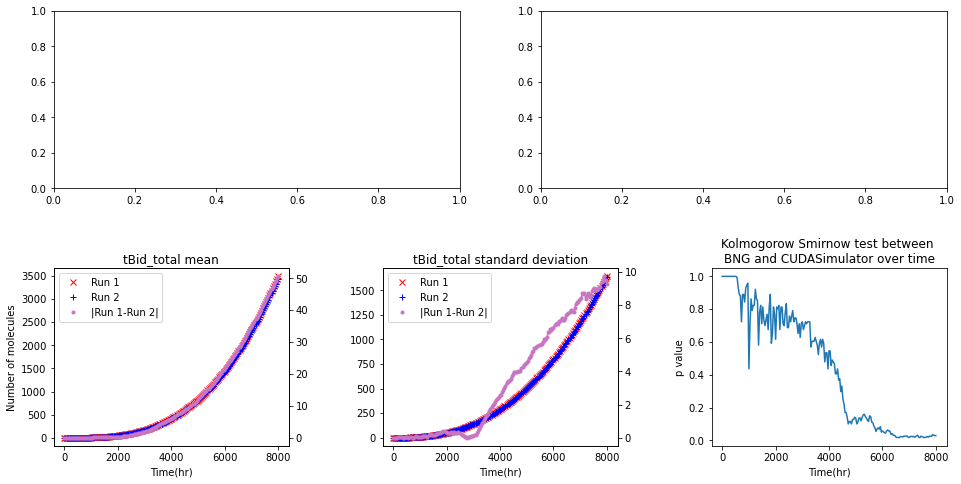

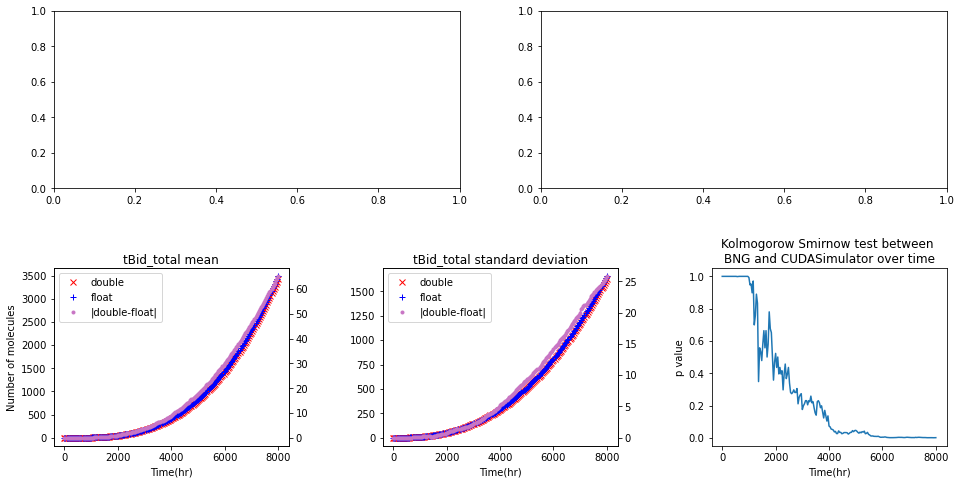

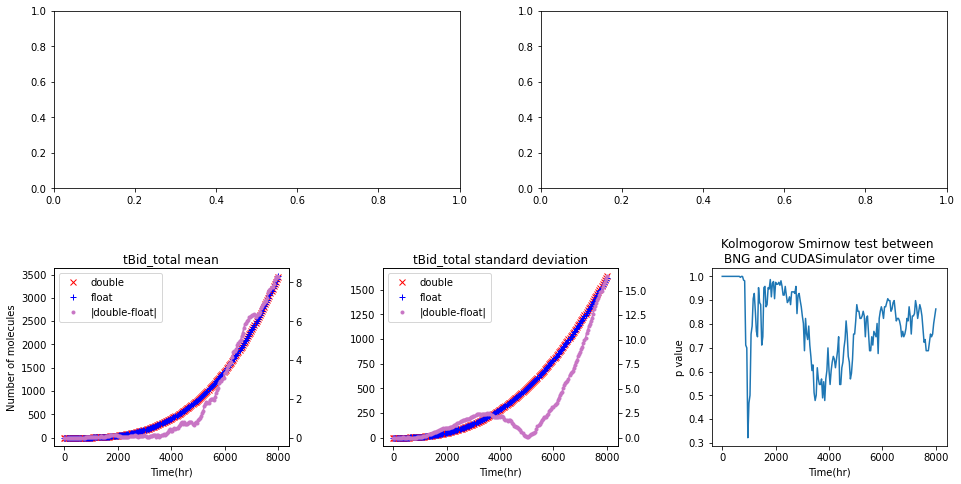

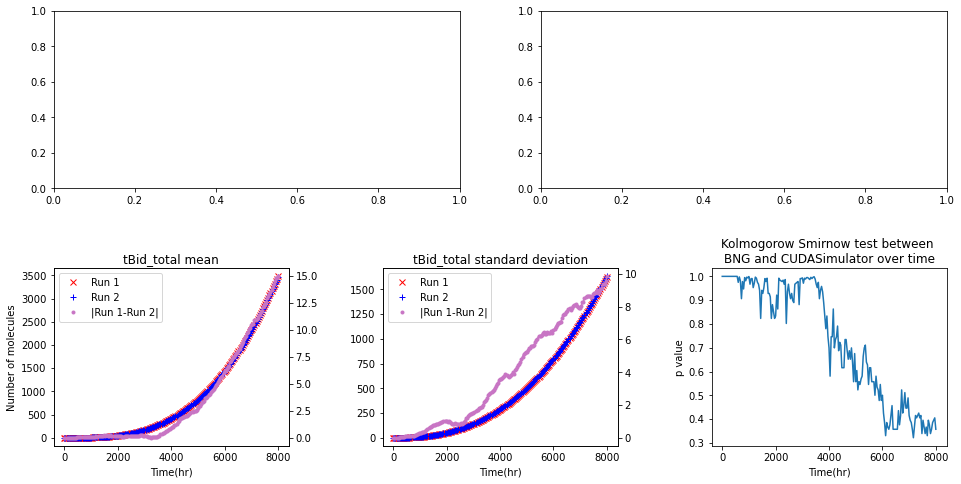

In [16]:
n_sim = 10000
os.environ['PYOPENCL_CTX'] = '0'
compare_opencl_twice(earm_1, 8000, 201, 'tBid_total', n_sim)
compare_opencl_precision(earm_1, 8000, 201, 'tBid_total', n_sim)
compare_cuda_precision(earm_1, 8000, 201, 'tBid_total', n_sim)
compare_cuda_twice(earm_1, 8000, 201, 'tBid_total', n_sim)

2021-01-22 13:27:12.583 - pysb - INFO - Logging started on PySB version 1.11.0+170.g43c73d5.dirty
2021-01-22 13:27:12.584 - pysb - INFO - Log entry time offset from UTC: -8.00 hours
2021-01-22 13:27:12.599 - pysb.simulator.cuda_ssa - INFO - [pysb.examples.kinase_cascade] Initialized CudaSSASimulator class
2021-01-22 13:27:12.600 - pysb.simulator.cuda_ssa - INFO - [pysb.examples.kinase_cascade] Simulation(s) started
2021-01-22 13:27:12.610 - pysb.simulator.cuda_ssa - INFO - [pysb.examples.kinase_cascade] Using device GeForce RTX 3090
2021-01-22 13:27:12.611 - pysb.simulator.cuda_ssa - INFO - [pysb.examples.kinase_cascade] Output cuda file to ssa_cuda_code.cu
2021-01-22 13:27:13.951 - pysb.simulator.cuda_ssa - INFO - [pysb.examples.kinase_cascade] Creating content on device
2021-01-22 13:27:14.058 - pysb.simulator.cuda_ssa - INFO - [pysb.examples.kinase_cascade] Completed transfer in: 0.1060s
2021-01-22 13:27:14.059 - pysb.simulator.cuda_ssa - INFO - [pysb.examples.kinase_cascade] Starti

min p: 0.1548386665118475 at time point 178.0


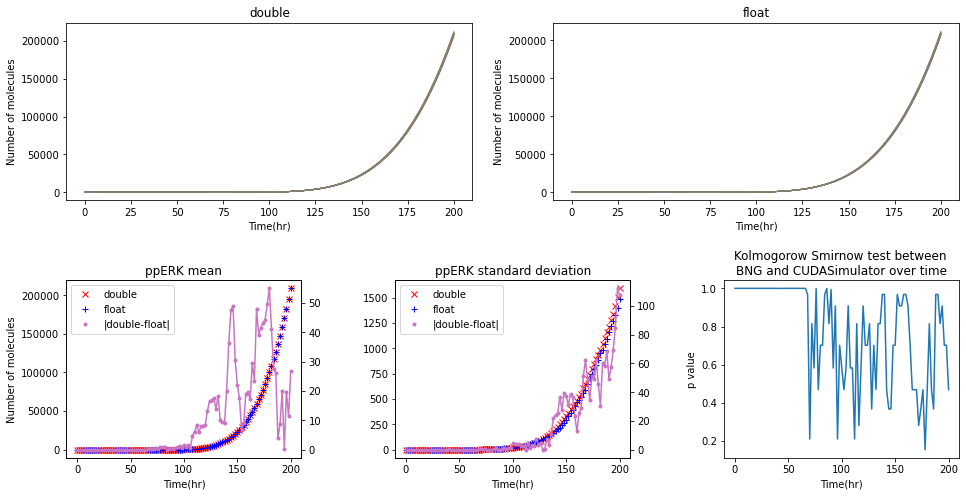

In [10]:
import os
os.environ['PYOPENCL_CTX'] = '1'
n_sim = 100
compare_cuda_precision(kinase_model, 200, 101, 'ppERK', n_sim)

                      __s0  __s1  X_total simulator
time     simulation                                
0.000000 0           250.0   1.0    250.0       bng
0.333333 0           194.0   1.0    194.0       bng
0.666667 0           153.0   1.0    153.0       bng
1.000000 0           131.0   1.0    131.0       bng
1.333333 0           118.0   1.0    118.0       bng
1.666667 0            99.0   1.0     99.0       bng
2.000000 0           105.0   1.0    105.0       bng
2.333333 0            96.0   1.0     96.0       bng
2.666667 0            74.0   1.0     74.0       bng
3.000000 0           109.0   1.0    109.0       bng
BNG StochKit 0.4253468503964972
BNG CUDASimulator 0.8228413328247728
BNG OpenCLSimulator 0.8547289084783269
StochKit CUDASimulator 0.30720493085574485
StochKit OpenCLSimulator 0.11677281598391237
CUDASimulator OpenCLSimulator 0.9518901680484947


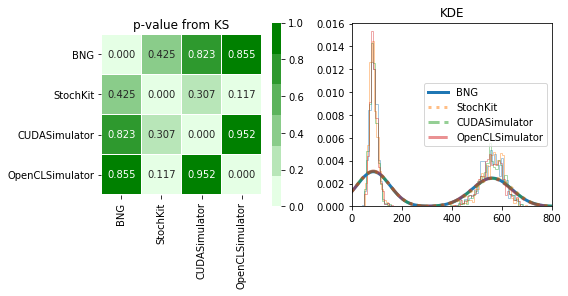

In [75]:
def load_traj(model, n_sim=1000):
    
    name = model.name.split('.')[-1]
    bng_file = "{name}_{n_sim}_{sim}.csv.gz".format(name=name, n_sim=n_sim, sim='bng')
    stochkit_file = "{name}_{n_sim}_{sim}.csv.gz".format(name=name, n_sim=n_sim, sim='stochkit')
    cuda_file = "{name}_{n_sim}_{sim}.csv.gz".format(name=name, n_sim=n_sim, sim='cuda')
    opencl_file = "{name}_{n_sim}_{sim}.csv.gz".format(name=name, n_sim=n_sim, sim='opencl')
    
    bng_data = pd.read_csv(bng_file, index_col=0)
    stochkit_data = pd.read_csv(stochkit_file, index_col=0)
    cuda_data = pd.read_csv(cuda_file, index_col=0)
    opencl_data = pd.read_csv(opencl_file, index_col=0)
    bng_data['simulator'] = 'bng'
    stochkit_data['simulator'] = 'stochkit'
    cuda_data['simulator'] = 'CUDASimulator'
    opencl_data['simulator'] = 'OpenCLSimulator'

    return bng_data, stochkit_data, cuda_data, opencl_data

def compare_schogl():
    traj1, traj2, traj3, traj4 = load_traj(scholgl_model, n_sim=1000)
    traj1.reset_index(inplace=True)
    traj2.reset_index(inplace=True)
    traj3.reset_index(inplace=True)
    traj4.reset_index(inplace=True)
    
    traj1.set_index(['time', 'simulation'], inplace=True)
    traj2.set_index(['time', 'simulation'], inplace=True)
    traj3.set_index(['time', 'simulation'], inplace=True)
    traj4.set_index(['time', 'simulation'], inplace=True)
    obs = 'X_total'
    n_sim = 1000
    tspan = np.linspace(0, 100, 201)
    scholgl_model.parameters['X_0'].value = 250
    
    traj1_species = traj1[obs].unstack('simulation').values
    traj2_species = traj2[obs].unstack('simulation').values
    traj3_species = traj3[obs].unstack('simulation').values
    traj4_species = traj4[obs].unstack('simulation').values
    all_traj = [traj1_species, traj2_species, traj3_species, traj4_species]
    n_traj = len(all_traj)
    labels = ['BNG', 'StochKit', 'CUDASimulator', 'OpenCLSimulator']
    zeros = np.zeros((n_traj,n_traj))
    for i in range(n_traj):
        for j in range(i, n_traj):
            if i == j:
                continue
            zeros[i, j] = stats.ks_2samp(all_traj[i][-1, :], all_traj[j][-1, :])[1]
            print(labels[i], labels[j], zeros[i, j])
            zeros[j, i] = zeros[i, j]
    plt.figure(figsize=(8, 4))
    
    plt.subplot(1,2, 1)
    plt.title("p-value from KS")
    sns.heatmap(zeros, cmap=sns.light_palette("green"),vmin=0, vmax=1,
                annot=True, fmt=".3f",square=True, linewidths=0.01,
                yticklabels=labels, xticklabels=labels)
    bins = 70
    hist = True
    plt.subplot(1,2, 2)
    plt.title("KDE")
    kde_kws={"lw": 3, 'alpha':1, 'linestyle':'-', 'label':'BNG'}
    hist_kws={"histtype": "step"}
    sns.distplot(traj1_species[-1, :], bins=bins, hist=hist, kde_kws=kde_kws, hist_kws=hist_kws)
    kde_kws={"lw": 3, 'alpha':.5, 'linestyle':'dotted', 'label':'StochKit'}
    sns.distplot(traj2_species[-1, :], bins=bins, hist=hist, kde_kws=kde_kws, hist_kws=hist_kws)
    kde_kws={"lw": 3, 'alpha':.5, 'linestyle':'dashed', 'label':'CUDASimulator'}
    sns.distplot(traj3_species[-1, :], bins=bins, hist=hist,kde_kws=kde_kws, hist_kws=hist_kws)
    kde_kws={"lw": 3, 'alpha':.5, 'linestyle':'dashdot', 'label':'OpenCLSimulator'}
    sns.distplot(traj4_species[-1, :], bins=bins, hist=hist,kde_kws=kde_kws, hist_kws=hist_kws)
    plt.legend(loc='center right')
    plt.xlim(0, 800)
    plt.tight_layout()
    out_name = 'compare_traj_schogl.png'
    plt.savefig(out_name, dpi=500, bbox_inches='tight')
compare_schogl()